# Load Packages

In [ ]:
import sys
import sklearn
import os
import numpy as np # NumPy
import pandas as pd # Panda
import seaborn as sns # Seaborn for plotting
import matplotlib as mpl # Matrix Plot Library
import matplotlib.pyplot as plt
from functools import partial
import PIL #Python Image Library
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Extract content
!unzip drive/MyDrive/dataset_final_2.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_final_2/images/without/8069_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._8069_train_0_.png  
  inflating: dataset_final_2/images/without/7182_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._7182_train_0_.png  
  inflating: dataset_final_2/images/without/5849_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._5849_train_0_.png  
  inflating: dataset_final_2/images/without/1612_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._1612_train_0_.png  
  inflating: dataset_final_2/images/without/1647_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._1647_train_0_.png  
  inflating: dataset_final_2/images/without/5417_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/without/._5417_train_0_.png  
  inflating: dataset_final_2/images/without/10312_train_0_.png  
  inflating: __MACOSX/dataset_final_2/images/witho

# Image Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
from keras.preprocessing import image

train_path = "/content/dataset_final_2/images"
valid_path = "/content/dataset_final_2/images"

batch_size = 64
#The dimension of the images we are going to define is 500x500
img_height = 150
img_width = 150


# train_ds = image_gen.image_dataset_from_directory(
#     "/content/dataset_final_2/images",
#     labels = 'inferred',
#     class_names = ['with', 'without'],
#     validation_split = 0.2,
#     subset = "training",
#     seed = 42,
#     image_size= (img_height, img_width),
#     batch_size = batch_size,
#     label_mode = 'binary'
# )
train = image_gen.flow_from_directory(
      "/content/dataset_final_2/images",
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
# validation_ds = test_data_gen.image_dataset_from_directory(
#     "/content/dataset_final_2/images",
#     labels = 'inferred',
#     class_names = ['with', 'without'],
#     validation_split = 0.2,
#     subset = "validation",
#     seed = 42,
#     image_size = (img_height, img_width),
#     batch_size = batch_size,
#     label_mode = 'binary'
# )
valid = test_data_gen.flow_from_directory(
      "/content/dataset_final_2/images",
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

len(valid)


Found 12047 images belonging to 2 classes.
Found 12047 images belonging to 2 classes.


189

In [ ]:
validation_ds.class_names

['with', 'without']

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 12047 images belonging to 2 classes.
Found 12047 images belonging to 2 classes.
Found 12047 images belonging to 2 classes.


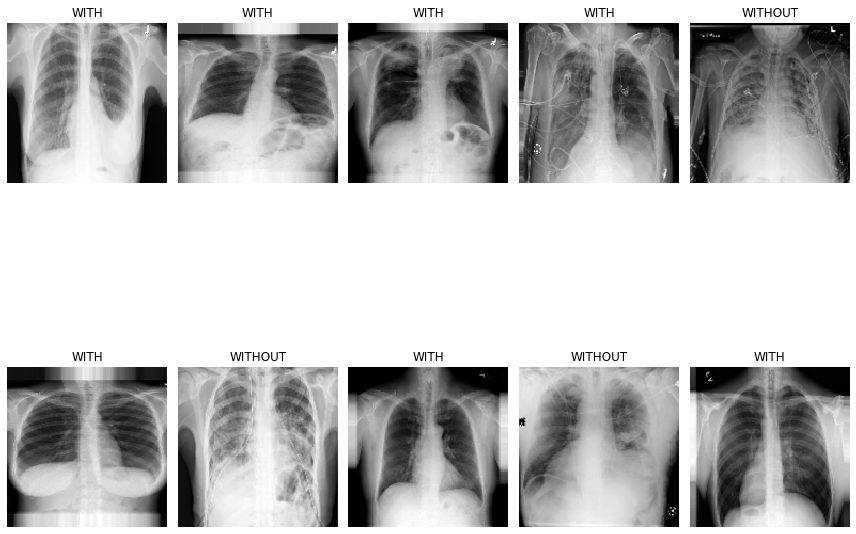

In [ ]:
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'WITHOUT', 1:'WITH'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap="gray",interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Sample Images

InvalidArgumentError: ignored

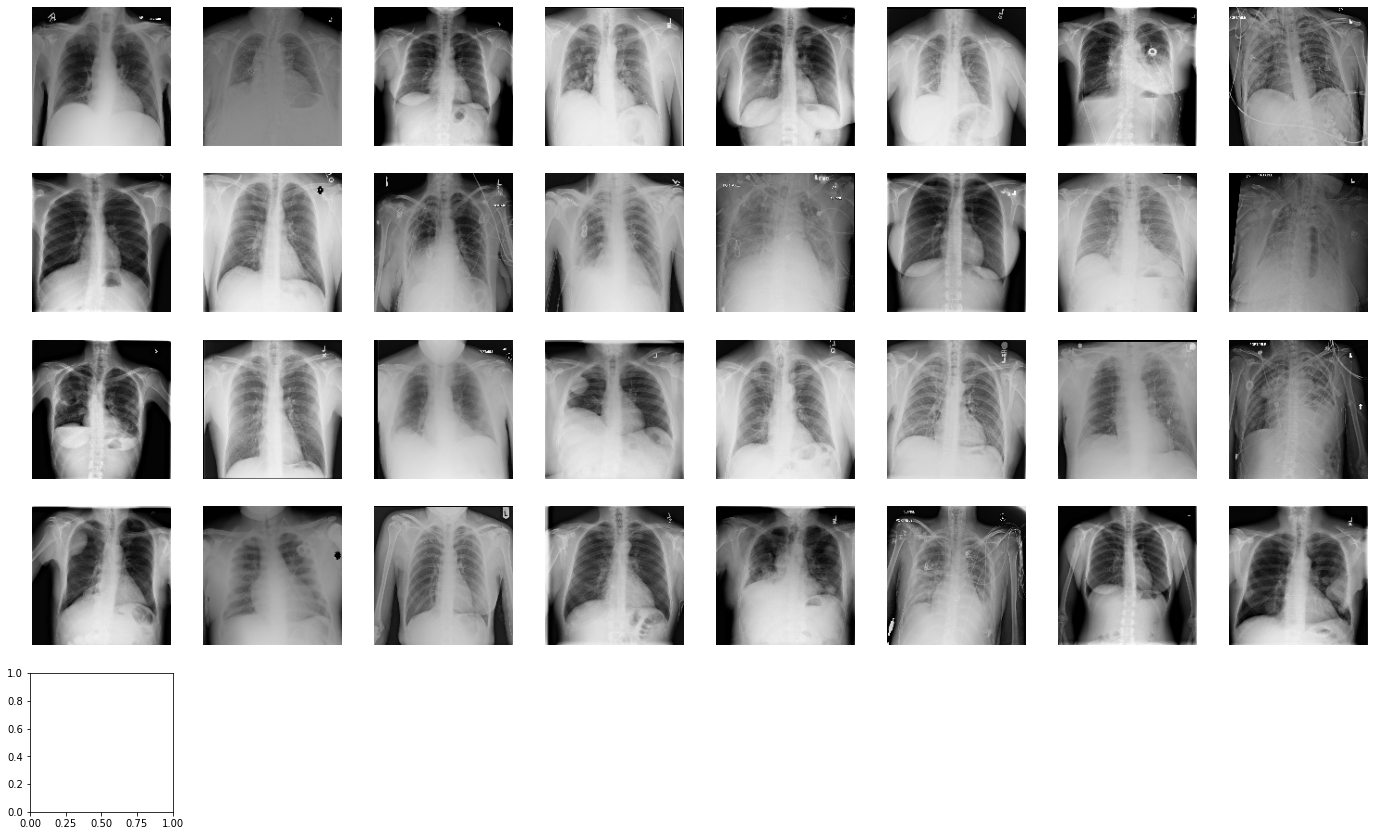

In [ ]:
class_names = train_ds.class_names # name of the building is the same as the folder where its images are stored.

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 8
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
plt.subplots_adjust(wspace=.2, hspace=.2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(height,width,color,channel)
    )
# Hyperparameters of MaxPooling2D
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

NameError: ignored

In [ ]:
base_model = keras.applications.resnet50.ResNet50(weights='imagenet',
                                                  include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=10)

Epoch 1/10
302/302 [==============================] - 120s 376ms/step - loss: 0.4821 - accuracy: 0.7768 - val_loss: 0.4244 - val_accuracy: 0.7991
Epoch 2/10
302/302 [==============================] - 113s 365ms/step - loss: 0.4303 - accuracy: 0.7960 - val_loss: 0.4219 - val_accuracy: 0.7987
Epoch 3/10
302/302 [==============================] - 116s 379ms/step - loss: 0.4224 - accuracy: 0.8021 - val_loss: 0.4141 - val_accuracy: 0.8082
Epoch 4/10
302/302 [==============================] - 114s 370ms/step - loss: 0.4172 - accuracy: 0.8036 - val_loss: 0.4121 - val_accuracy: 0.8078
Epoch 5/10
302/302 [==============================] - 114s 371ms/step - loss: 0.4148 - accuracy: 0.8038 - val_loss: 0.4098 - val_accuracy: 0.8115
Epoch 6/10
302/302 [==============================] - 116s 376ms/step - loss: 0.4129 - accuracy: 0.8048 - val_loss: 0.4103 - val_accuracy: 0.8074
Epoch 7/10
302/302 [==============================] - 115s 374ms/step - loss: 0.4111 - accuracy: 0.8060 - val_loss: 0.4083 -

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.001, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=10)

Epoch 1/10
302/302 [==============================] - 149s 466ms/step - loss: 0.4722 - accuracy: 0.7818 - val_loss: 0.4393 - val_accuracy: 0.7970
Epoch 2/10
302/302 [==============================] - 141s 460ms/step - loss: 0.4059 - accuracy: 0.8119 - val_loss: 0.4376 - val_accuracy: 0.8012
Epoch 3/10
302/302 [==============================] - 139s 454ms/step - loss: 0.3711 - accuracy: 0.8293 - val_loss: 0.4203 - val_accuracy: 0.8140
Epoch 4/10
302/302 [==============================] - 139s 453ms/step - loss: 0.3454 - accuracy: 0.8462 - val_loss: 0.4426 - val_accuracy: 0.7954
Epoch 5/10
302/302 [==============================] - 140s 457ms/step - loss: 0.3258 - accuracy: 0.8569 - val_loss: 0.4746 - val_accuracy: 0.7704
Epoch 6/10
302/302 [==============================] - 141s 458ms/step - loss: 0.3078 - accuracy: 0.8690 - val_loss: 0.3920 - val_accuracy: 0.8161
Epoch 7/10
302/302 [==============================] - 140s 455ms/step - loss: 0.2939 - accuracy: 0.8781 - val_loss: 0.4123 -

In [ ]:
model.evaluate(validation_ds)

76/76 [==============================] - 24s 285ms/step - loss: 0.4138 - accuracy: 0.8086


[0.4137737452983856, 0.8086342811584473]

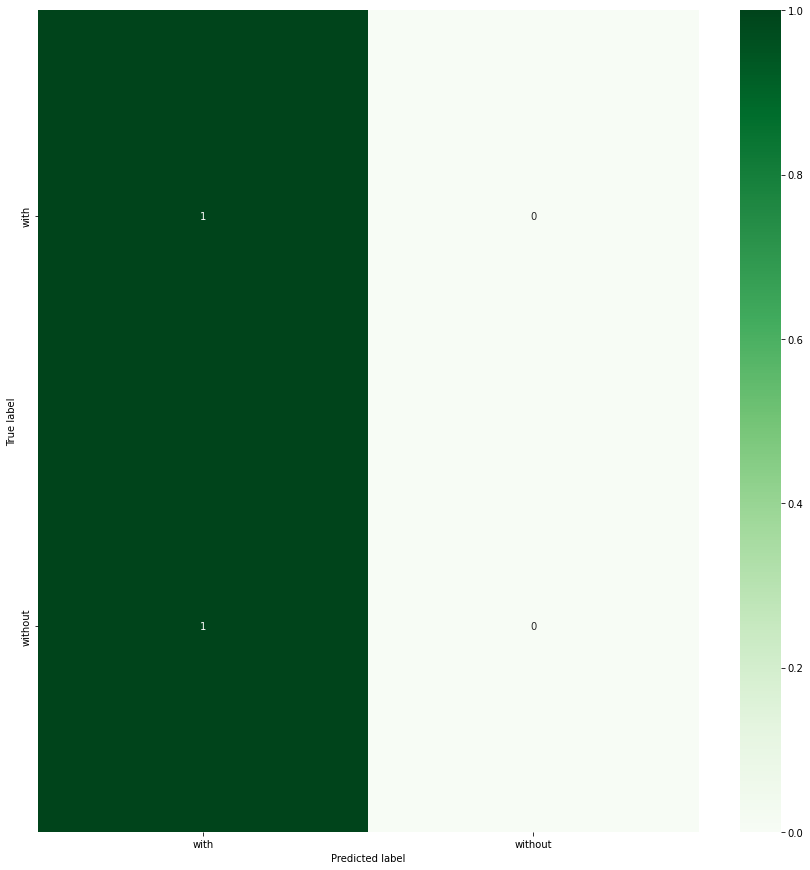

In [ ]:
import pandas as pd
import seaborn as sns
validation_ds = validation_ds.cache().prefetch(buffer_size = 10)
y_pred = model.predict(validation_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([label for image, label in validation_ds], axis=0)
conf_matrix = tf.math.confusion_matrix(labels=true_categories, predictions=predicted_categories).numpy()

conf_matrix_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

conf_matrix_df = pd.DataFrame(conf_matrix_norm,
                     index = class_names,
                     columns = class_names)

figure = plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_df, annot=True,cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))

    plt.imshow(img1)

    Y = image.img_to_array(img1)

    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:

        plt.xlabel("With",fontsize=30)


    elif val == 0:

        plt.xlabel("Without",fontsize=30)

[[0.63611186]]


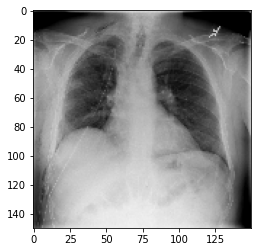

In [ ]:
predictImage("/content/dataset_final_2/images/with/1012_train_1_.png")

[[0.66296893]]


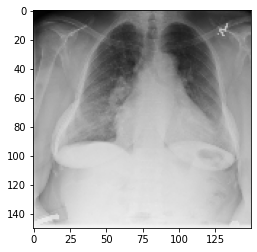

In [ ]:
predictImage("/content/dataset_final_2/images/without/10002_train_0_.png")